In [86]:
# Import libraries
import numpy as np
import pandas as pd
import cvxpy as cp

import os

from datetime import datetime
import pandas_market_calendars as mcal

import matplotlib.pyplot as plt

In [ ]:
# Initialize global variables
# Load data
opt_dates = os.listdir("assets")
historical_data = pd.read_csv("historical_data.csv").set_index("Date")

# Indexes
start_idx = 0
end_idx = 25 #len(opt_dates)
lookback = 756

# Memories 
all_w = pd.DataFrame()
all_rets = pd.Series()

# Obtain formatted dates
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule('2000-01-01','2030-01-01')
trading_days = schedule.index

all_dates = list(historical_data.index)
all_dates = [ int(datetime.strptime(x, '%Y-%m-%d').strftime('%Y%m%d')) for x in all_dates ]


The MVP maximizes: $$w’ \mu - \frac{\lambda}{2}w’ \sum w$$ subject to $1’w=1$ and $w \ge 0$, where $\lambda$ is a hyper-parameter that controls how risk averse the investor is. An idea would be to estimate $\lambda$ using a cross-validation dataset within the in-sample data. 

In [88]:
# Vanilla MVP function
def MVP_lmd(X_log, lmd=1):
    # Estimate mu and Sigma with training data
    mu = X_log.mean().values
    sigma = X_log.cov().values

    # Initialize variables and constraints
    N = len(sigma)
    weights = cp.Variable(N) # Vector variable "weights" of size N that will be optimized using train data. 
    constraints = [cp.sum(weights) == 1, weights >= 0] # Define capital budget, and long-only constraint

    prob = cp.Problem(cp.Maximize(mu @ weights - (lmd/2) * cp.quad_form(weights, sigma)), constraints) # Form the problem (formula above)
    prob.solve() # Find the optimal value of the problem above 
    return weights.value # Return a vector containing optimal weight allocations across the N assets

In [89]:
# Function for cross-validating lambda in MVP
def estimate_lmd(X_log, X_lin, lambdas):
    lmd_performance = {}
    
    # Split in-sample data in 70-30 train data and validation data
    T = X_log.shape[0]
    T_split = round(0.70*T)

    X_lin_val =  X_lin[T_split:]
    X_log_trn = X_log[:T_split]

    # Compute weights and returns for each lambda
    for lmd in lambdas:
        w_MVP = MVP_lmd(X_log_trn, lmd)
        ret_MVP = X_lin_val @ w_MVP

        # Measure performance based on Sharpe ratio
        sharpe_ratio = ret_MVP.mean() / (ret_MVP.std() + 1e-8)
        lmd_performance[lmd] = sharpe_ratio

    # Use the lambda with the highest Sharpe ratio
    best_lmd = max(lmd_performance, key=lmd_performance.get)
    print(f"The best lambda value is {best_lmd} with a Sharpe ratio of {lmd_performance[best_lmd]}")
    return best_lmd

In [90]:
# Function that finds the lookback day necessary for the in-sample dataset window   
def shift_trading_days(start_date, lookback=252):
    start_date = pd.Timestamp(start_date)
    idx = trading_days.get_loc(start_date)
    return trading_days[idx - lookback]

In [91]:
# Function for backtesting the vanilla MVP 
def backtest(prices, str_test, end_test, lookback):
    prices = prices.dropna(axis=1, how='any')

    # Calculate linear and logarithmic returns; Remove NaN to prevent errors
    X_lin = prices.pct_change().dropna()
    X_log = np.log1p(X_lin)
    
    # Define train and test data
    lkback_date = shift_trading_days(str_test, lookback)
    X_lin_test =  X_lin[str_test:end_test]
    X_lin_trn = X_lin[str(lkback_date):str_test]
    X_log_trn = X_log[str(lkback_date):str_test]

    # Initialize variables
    N = X_lin.shape[1] 
    current_w = np.repeat(0, N) 
    portf_w = pd.DataFrame(index=X_lin.index, columns=X_lin.columns) 
    portf_ret = pd.Series(index=X_lin.index)

    # Estimate lambda using cross-validation 
    print("Cross-validating lambda based on Sharpe ratio...")
    lambdas = np.linspace(1, 64, 25)
    best_lmd = estimate_lmd(X_log_trn, X_lin_trn, lambdas)

    # Design portfolio weights
    print("Designing vanilla MVP...")
    current_w = MVP_lmd(X_log_trn, best_lmd)

    # Backtest portfolio day-to-day with test data
    print("Backtesting vanilla MVP...")
    for t in X_lin_test.index:
        # Store weights
        portf_w.loc[t] = current_w

        # Compute portfolio return
        portf_ret.loc[t] = X_lin.loc[t] @ current_w

        # Normalize weights based on asset performance to avoid weight drift
        current_w = current_w * (1 + X_lin.loc[t])
        current_w = current_w / current_w.sum()

    return portf_ret.dropna(), portf_w.dropna(how="all")


In [92]:
# Will cycle through the monthly constituents and backtest the portfolios with the available data
while start_idx < end_idx:
    # Load constituents and save ones we have price data for as "exst_consts"
    consts = pd.read_csv("assets\\" + opt_dates[start_idx]).set_index("rank")
    exst_consts = set(consts["ticker"]).intersection(historical_data.columns)
    exst_consts = historical_data[list(exst_consts)]

    # Obtain the train + test data by period
    str_test = datetime.strptime(opt_dates[start_idx][6:-4], '%Y%m%d').strftime('%Y-%m-%d')
    end_test = datetime.strptime(str(int(opt_dates[start_idx + 1][6:-4]) - 1), '%Y%m%d').strftime('%Y-%m-%d') 
    exst_data = exst_consts.loc[:end_test]
    print(f"Running backtest {start_idx}. Reoptimization as of: {str_test}")

    portf_ret, portf_w = backtest(exst_data, str_test, end_test, lookback)
    print("Backtesting completed \n")
    
    all_rets = pd.concat([all_rets, portf_ret])
    all_w = pd.concat([all_w, portf_w]) 

    start_idx += 1

Running backtest 0. Reoptimization as of: 2009-01-30
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 3.625 with a Sharpe ratio of 0.1732078617265437
Designing vanilla MVP...
Backtesting vanilla MVP...
Backtesting completed 

Running backtest 1. Reoptimization as of: 2009-02-27
Cross-validating lambda based on Sharpe ratio...


C:\Users\vladp\AppData\Local\Temp\ipykernel_21172\4216160545.py:17: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_rets = pd.concat([all_rets, portf_ret])


The best lambda value is 1.0 with a Sharpe ratio of 0.18009435396638268
Designing vanilla MVP...
Backtesting vanilla MVP...
Backtesting completed 

Running backtest 2. Reoptimization as of: 2009-03-31
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 14.125 with a Sharpe ratio of 0.10779733004249643
Designing vanilla MVP...
Backtesting vanilla MVP...
Backtesting completed 

Running backtest 3. Reoptimization as of: 2009-04-30
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 16.75 with a Sharpe ratio of 0.10915519705839084
Designing vanilla MVP...
Backtesting vanilla MVP...
Backtesting completed 

Running backtest 4. Reoptimization as of: 2009-05-29
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 16.75 with a Sharpe ratio of 0.1458086755698625
Designing vanilla MVP...
Backtesting vanilla MVP...
Backtesting completed 

Running backtest 5. Reoptimization as of: 2009-06-30
Cross-validating lambda based on Sharpe rat

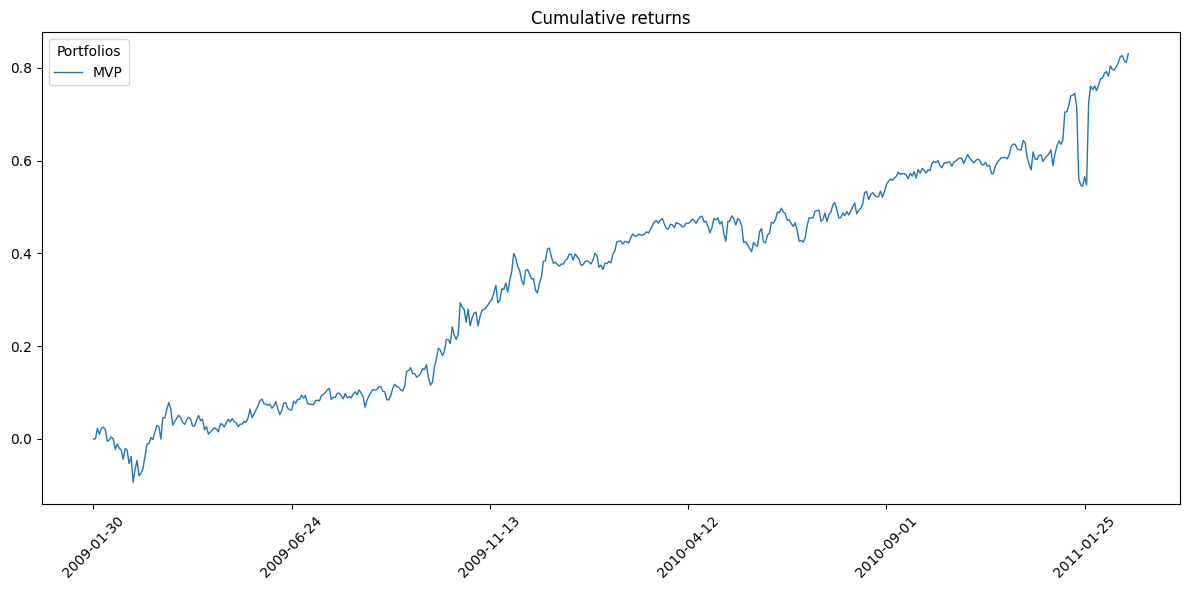

In [ ]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
cum_ret = (1 + all_rets).cumprod() - 1
cum_ret.plot(label='MVP', linewidth=1)
plt.title('Cumulative returns')
plt.legend(title='Portfolios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()